# Imports

In [75]:
import os
import cv2
import tensorflow as tf
import numpy as np
import wandb
import imageio #2.23.0

from typing import List, Optional, Sequence, Tuple, Union
from matplotlib import pyplot as plt
from PIL import Image
from wandb.keras import WandbMetricsLogger

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Data Loader

## Download the GRID dataset

In [6]:
import gdown

In [5]:
# url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
# output = 'data.zip'
# gdown.download(url, output, quiet=False)
# gdown.extractall('data.zip')

Downloading...
From (uriginal): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=9b199cb1-d72d-432c-847d-9635b46e3153
To: /home/sadat/Desktop/LipNet/data.zip
100%|████████████████████████████████████████| 423M/423M [00:13<00:00, 31.5MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

## Loading the video frames

In [7]:
def load_video(path:str) -> List[float]:
    """Loads the frames of a video file, converts frames to grayscale,
    crops the mouth, and standardises the frames.
    
    Args:
        path (string): Path for the video file.
        
    Returns:
        List[float]: Frames of the video in a tensor.
    """
    cap = cv2.VideoCapture(path)
    frames = []
    
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        flag, frame = cap.read()
        
        if not flag:
            return
        
        frame = tf.image.rgb_to_grayscale(frame)
        
        # Crop using static co-ords (could use another model to get exact lips location)
        frames.append(frame[190:236, 80:220, :])
        
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    
    return tf.cast((frames-mean), tf.float32) / std

## Tokens

In [8]:
# Create our vocab list
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [9]:
# Function to convert num to char
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")

# Function to convert char to num
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

2023-06-22 03:44:39.014683: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-22 03:44:39.014932: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-22 03:44:39.015087: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [10]:
char_to_num(['a', 'b', 'd'])

<tf.Tensor: shape=(3,), dtype=int64, numpy=array([1, 2, 4])>

In [11]:
num_to_char([1, 2, 4])

<tf.Tensor: shape=(3,), dtype=string, numpy=array([b'a', b'b', b'd'], dtype=object)>

## Loading Alignments

In [12]:
def load_alignments(path:str) -> np.ndarray: 
    """ Loads the alignments and tokenizes them.
    Args:
        path (str): Path to the alignment file.
        
    Returns:
        np.ndarray: Tokens in a tensor.
    """
    with open(path, 'r') as f: 
        lines = f.readlines() 
        
    tokens = []
    
    for line in lines:
        line = line.split()
        
        # Ignore start/end string 'sil'
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
            
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

## Loading both

In [13]:
def get_dir_filename(path: str) -> Union[np.ndarray, str]:
    """Returns a list of directories and the filename.
    Args:
        path (str): A path.
        
    Returns:
        np.ndarray: The directories.
        string: Filename.
    """
    path, file_name = os.path.split(path)
    directories = []

    while True:
        path, directory = os.path.split(path)
        if directory != "":
            directories.append(directory)
        else:
            if path != "":
                directories.append(path)
            break
    # Reverse the directories list
    directories = directories[::-1]
            
    return directories, file_name

In [14]:
get_dir_filename('./dir1/dir2/file')

(['.', 'dir1', 'dir2'], 'file')

In [15]:
def load_data(path: tf.Tensor) -> Union[np.ndarray, np.ndarray]:
    """Returns the loaded frames and alignements using video path.
    Args:
        path (tf.Tensor): The path to the video file.
    Returns:
        np.ndarray: Frames of the video in a tensor.
        np.ndarray: Tokens in a tensor.
        """
    path = bytes.decode(path.numpy())

    dirs, file_name = get_dir_filename(path)
    
    # Remove the extension
    file_name = file_name.split('.')[0]
    
    video_path = path
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

## Testing

In [22]:
path = './data/s1/bbaf2n.mpg'
dirs, file_name = get_dir_filename(path)
file_name = file_name.split('.')[0]
video_path = path
alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')

In [17]:
path

'./data/s1/bbaf2n.mpg'

In [18]:
dirs, file_name = get_dir_filename(path)
file_name.split('.')[0]

'bbaf2n'

In [19]:
load_alignments(alignment_path)

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39,  6, 39, 20, 23, 15,
       39, 14, 15, 23])>

In [21]:
load_video(video_path).shape

TensorShape([75, 46, 140, 1])

In [ ]:
frames, alignments = load_data(tf.convert_to_tensor(video_path))

In [ ]:
frames.shape

In [ ]:
alignments

In [ ]:
''.join([bytes.decode(x.numpy()) for x in num_to_char(alignments)])

## Mapping Function

In [23]:
# Wrap load_data function into a TensorFlow op
def mappable_function(path: str) -> List[str]:
    # Note: This is one of TF's nuances; I have no clue what this does :|
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# Data Pipeline

In [79]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500)
# Maps the data to our data loader
data = data.map(mappable_function)
# Get batch size of 2, pad 75 frames and 40 tokens
data = data.padded_batch(2, padded_shapes=([75, None, None, None], [40]))
data = data.prefetch(tf.data.AUTOTUNE)

# Split the dataset
train = data.take(450)
test = data.skip(450)

In [80]:
frames, alignments = data.as_numpy_iterator().next()
len(frames)

2023-06-22 06:20:51.592285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-06-22 06:20:51.592589: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]


2

In [81]:
frames.shape

(2, 75, 46, 140, 1)

In [82]:
alignments.shape

(2, 40)

In [83]:
iter_ = data.as_numpy_iterator()

In [84]:
val = next(iter_)

In [85]:
val[0][0].shape

(75, 46, 140, 1)

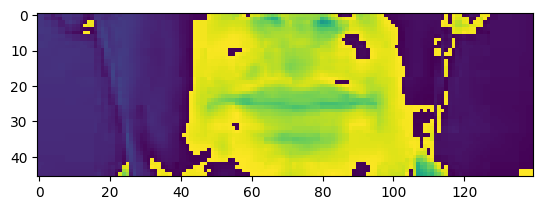

In [86]:
plt.imshow(val[0][0][0])

In [87]:
# Create GIF
imageio.mimsave('./animation.gif', val[0][0], fps=10)

Lossy conversion from float32 to uint8. Range [0.0, 9.789384841918945]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.789384841918945]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.789384841918945]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.789384841918945]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.789384841918945]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.789384841918945]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.789384841918945]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. R

Lossy conversion from float32 to uint8. Range [0.0, 9.789384841918945]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.789384841918945]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.789384841918945]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.789384841918945]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.789384841918945]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.789384841918945]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.789384841918945]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. R

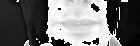

In [88]:
# Groundtruth
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'place green by k six now'>

# Model

In [89]:
val[0][0].shape

(75, 46, 140, 1)

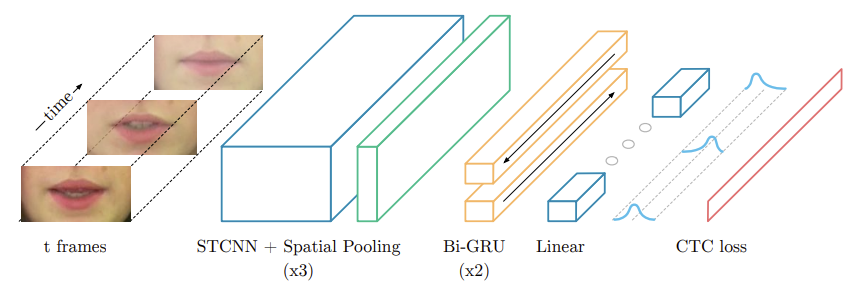

https://github.com/rizkiarm/LipNet

In [90]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [91]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

# Separate each time unit from the 75 units to be fed into our LSTM
model.add(TimeDistributed(Flatten()))

# Note: The paper uses GRU but we used an LSTM here; in the future, I want to use a transformer
model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

2023-06-22 06:20:53.279826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-22 06:20:53.280692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-22 06:20:53.281350: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [92]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 75, 46, 140, 128)  3584      
                                                                 
 activation_3 (Activation)   (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 75, 23, 70, 128)  0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_4 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                  

In [93]:
# Test the model
yhat = model.predict(val[0])

2023-06-22 06:20:53.785687: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-22 06:20:53.786660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-22 06:20:53.787355: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 576ms/step


In [94]:
tf.argmax(yhat)

<tf.Tensor: shape=(75, 41), dtype=int64, numpy=
array([[1, 1, 0, ..., 0, 1, 1],
       [1, 1, 0, ..., 0, 0, 1],
       [1, 1, 0, ..., 0, 0, 1],
       ...,
       [0, 1, 1, ..., 0, 1, 1],
       [0, 1, 1, ..., 0, 1, 1],
       [0, 1, 1, ..., 0, 1, 1]])>

In [95]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'dd77hhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh'>

## Training

In [96]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [97]:
# Copied from https://keras.io/examples/audio/ctc_asr/#model
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    # No documentation on Tensorflow on what this does
    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [98]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [99]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [100]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 

In [101]:
schedule_callback = LearningRateScheduler(scheduler)

In [102]:
example_callback = ProduceExample(data)

In [103]:
wandb.init(entity="cares", project="lipNet",
            group="baseline",
            config={
            "learning_rate": 0.0001,
            "architecture": "LipNet",
            "dataset": "GRID",
            "epochs": 10,
            })

In [ ]:
model.fit(train, validation_data=test, epochs=200, callbacks=[WandbMetricsLogger(), checkpoint_callback, schedule_callback, example_callback])

Epoch 1/200
158/450 [=========>....................] - ETA: 1:15 - loss: 68.1263

[mpeg1video @ 0x7f934406ef40] ac-tex damaged at 22 17
[mpeg1video @ 0x7f934406ef40] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 66.9130

[mpeg1video @ 0x7f95340168c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f95340168c0] Warning MVs not available


1/1 [==============================] - 0s 33ms/step
Original: lay red sp with l five soon
Prediction: la e e t e on
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place blue by p two now
Prediction: la e e e on
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 231s 514ms/step - loss: 66.9130 - val_loss: 61.9414 - lr: 1.0000e-04
Epoch 2/200
207/450 [============>.................] - ETA: 1:02 - loss: 64.4502

[mpeg1video @ 0x7f9310042140] ac-tex damaged at 22 17
[mpeg1video @ 0x7f9310042140] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 64.2415

[mpeg1video @ 0x7f95bc800940] ac-tex damaged at 22 17
[mpeg1video @ 0x7f95bc800940] Warning MVs not available


1/1 [==============================] - 0s 28ms/step
Original: set blue by a eight now
Prediction: la e t e eo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay blue in j seven soon
Prediction: la e t e eo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 229s 509ms/step - loss: 64.2415 - val_loss: 61.1278 - lr: 1.0000e-04
Epoch 3/200
434/450 [===========================>..] - ETA: 4s - loss: 62.1601

[mpeg1video @ 0x7f9510024f80] ac-tex damaged at 22 17
[mpeg1video @ 0x7f9510024f80] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 62.1937

[mpeg1video @ 0x7f947a16c400] ac-tex damaged at 22 17
[mpeg1video @ 0x7f947a16c400] Warning MVs not available


1/1 [==============================] - 0s 29ms/step
Original: bin blue in r nine again
Prediction: la re t e ean
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place white at q three again
Prediction: la re t e eao
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 249s 554ms/step - loss: 62.1937 - val_loss: 58.7320 - lr: 1.0000e-04
Epoch 4/200
280/450 [=================>............] - ETA: 44s - loss: 60.6714

[mpeg1video @ 0x7f95d8021000] ac-tex damaged at 22 17
[mpeg1video @ 0x7f95d8021000] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 60.4888

[mpeg1video @ 0x7f9c68058b40] ac-tex damaged at 22 17
[mpeg1video @ 0x7f9c68058b40] Warning MVs not available


1/1 [==============================] - 0s 35ms/step
Original: set green by c nine again
Prediction: la re t e eao
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set green by x one again
Prediction: la re t e ean
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 244s 543ms/step - loss: 60.4888 - val_loss: 56.2327 - lr: 1.0000e-04
Epoch 5/200
112/450 [======>.......................] - ETA: 1:46 - loss: 59.2585

[mpeg1video @ 0x7f9358057140] ac-tex damaged at 22 17
[mpeg1video @ 0x7f9358057140] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 59.0651

[mpeg1video @ 0x7f931403dd40] ac-tex damaged at 22 17
[mpeg1video @ 0x7f931403dd40] Warning MVs not available


1/1 [==============================] - 0s 35ms/step
Original: bin green by u three soon
Prediction: la re t e ean
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set green by j one soon
Prediction: la re t e ean
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 257s 572ms/step - loss: 59.0651 - val_loss: 54.8151 - lr: 1.0000e-04
Epoch 6/200
308/450 [===================>..........] - ETA: 34s - loss: 57.6389

[mpeg1video @ 0x7f95f8058940] ac-tex damaged at 22 17
[mpeg1video @ 0x7f95f8058940] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 57.2567

[mpeg1video @ 0x7f936c0b1740] ac-tex damaged at 22 17
[mpeg1video @ 0x7f936c0b1740] Warning MVs not available


1/1 [==============================] - 0s 30ms/step
Original: place green at e one again
Prediction: la re t e on
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set blue in a zero now
Prediction: la re t e on
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 207s 460ms/step - loss: 57.2567 - val_loss: 51.8167 - lr: 1.0000e-04
Epoch 7/200
322/450 [====================>.........] - ETA: 31s - loss: 53.4027

[mpeg1video @ 0x7f953c010040] ac-tex damaged at 22 17
[mpeg1video @ 0x7f953c010040] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 53.3954

[mpeg1video @ 0x7f942c1884c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f942c1884c0] Warning MVs not available


1/1 [==============================] - 0s 33ms/step
Original: place red with k zero please
Prediction: la re t e ean
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set blue with h nine again
Prediction: la re t e eae
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 215s 477ms/step - loss: 53.3954 - val_loss: 48.9674 - lr: 1.0000e-04
Epoch 8/200
387/450 [========================>.....] - ETA: 15s - loss: 51.6356

[mpeg1video @ 0x7f95e80856c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f95e80856c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 51.4186

[mpeg1video @ 0x7f95481e1340] ac-tex damaged at 22 17
[mpeg1video @ 0x7f95481e1340] Warning MVs not available


1/1 [==============================] - 0s 31ms/step
Original: set red with i five again
Prediction: la re t e on
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin blue in l two now
Prediction: la re n o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 220s 489ms/step - loss: 51.4186 - val_loss: 48.3699 - lr: 1.0000e-04
Epoch 9/200
 32/450 [=>............................] - ETA: 1:53 - loss: 50.5966

[mpeg1video @ 0x7f93f005a900] ac-tex damaged at 22 17
[mpeg1video @ 0x7f93f005a900] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 49.6027

[mpeg1video @ 0x7f95b4076c80] ac-tex damaged at 22 17
[mpeg1video @ 0x7f95b4076c80] Warning MVs not available


1/1 [==============================] - 0s 38ms/step
Original: lay red at y four now
Prediction: la re i o o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin white with n eight please
Prediction: la re t e ean
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 243s 540ms/step - loss: 49.6027 - val_loss: 47.1176 - lr: 1.0000e-04
Epoch 10/200
265/450 [================>.............] - ETA: 53s - loss: 48.3578